In [927]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [928]:
df = pd.read_csv('./data/sea_turtle_population_data.csv',parse_dates=['Date'],index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1984-10-01 to 2020-07-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sea_turtle_count  144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


<AxesSubplot:xlabel='Date'>

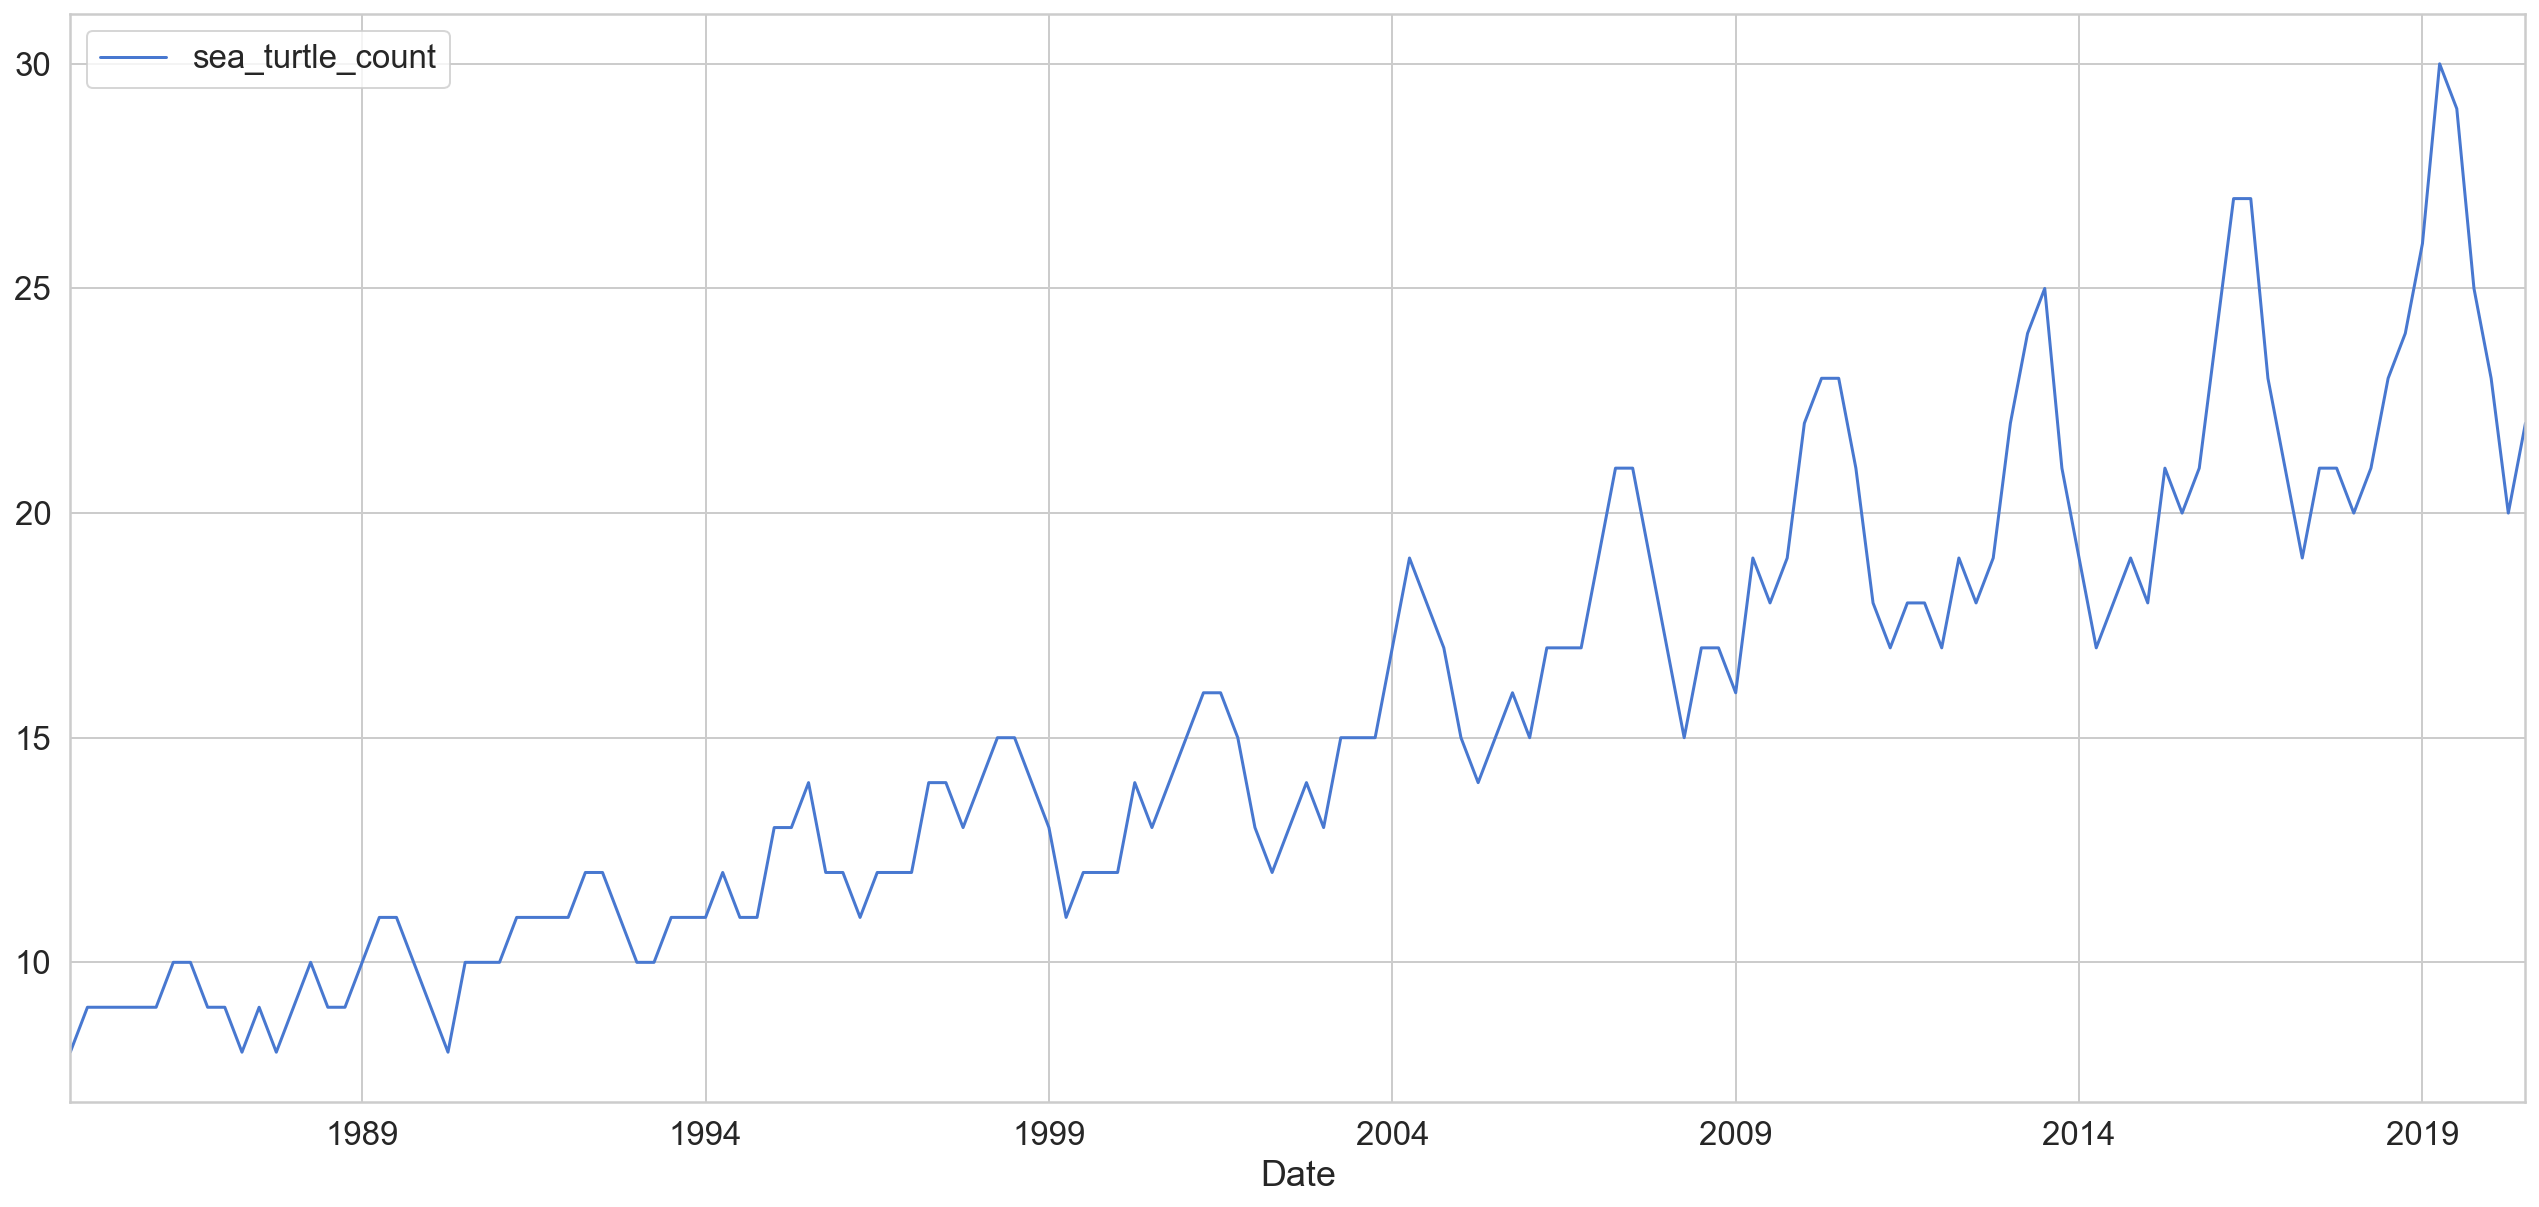

In [929]:
df.plot(y="sea_turtle_count")

In [930]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

115 29


In [931]:
f_columns = ['sea_turtle_count']

scaler = MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = scaler.transform(train[f_columns].to_numpy())

test.loc[:, f_columns] = scaler.transform(test[f_columns].to_numpy())

In [932]:
train

,sea_turtle_count
Date,
1984-10-01,0.0000
1985-01-01,0.0625
1985-04-01,0.0625
1985-07-01,0.0625
1985-10-01,0.0625
...,...
2012-04-01,0.6875
2012-07-01,0.6250
2012-10-01,0.6875


In [933]:
test

,sea_turtle_count
Date,
2013-07-01,1.0625
2013-10-01,0.8125
2014-01-01,0.6875
2014-04-01,0.5625
2014-07-01,0.6250
2014-10-01,0.6875
2015-01-01,0.6250
2015-04-01,0.8125
2015-07-01,0.7500


In [934]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences.iloc[i:end_ix, :].values, sequences.iloc[end_ix:out_end_ix, :].values
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [935]:
n_steps_in, n_steps_out = 12, 8

X_train, y_train = split_sequences(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)

n_features = X_train.shape[2]

n_features

1

In [936]:
X_train.shape

(96, 12, 1)

In [937]:
y_train.shape

(96, 8, 1)

In [938]:
X_test.shape

(10, 12, 1)

In [939]:
y_test.shape

(10, 8, 1)

In [940]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(20, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.RepeatVector(n_steps_out))
model.add(tf.keras.layers.LSTM(12, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(13, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(12, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

In [941]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (None, 20)                1760      
_________________________________________________________________
dropout_115 (Dropout)        (None, 20)                0         
_________________________________________________________________
repeat_vector_36 (RepeatVect (None, 8, 20)             0         
_________________________________________________________________
lstm_148 (LSTM)              (None, 8, 12)             1584      
_________________________________________________________________
dropout_116 (Dropout)        (None, 8, 12)             0         
_________________________________________________________________
lstm_149 (LSTM)              (None, 8, 13)             1352      
_________________________________________________________________
dropout_117 (Dropout)        (None, 8, 13)           

In [942]:
history = model.fit(X_train, y_train, epochs=60, validation_split=0.2)

Epoch 1/60
3/3 [==============================] - 1s 363ms/step - loss: 0.1277 - val_loss: 0.4605
Epoch 2/60
3/3 [==============================] - 0s 50ms/step - loss: 0.1219 - val_loss: 0.4469
Epoch 3/60
3/3 [==============================] - 0s 44ms/step - loss: 0.1156 - val_loss: 0.4328
Epoch 4/60
3/3 [==============================] - 0s 47ms/step - loss: 0.1098 - val_loss: 0.4180
Epoch 5/60
3/3 [==============================] - 0s 53ms/step - loss: 0.1039 - val_loss: 0.4021
Epoch 6/60
3/3 [==============================] - 0s 45ms/step - loss: 0.0972 - val_loss: 0.3850
Epoch 7/60
3/3 [==============================] - 0s 41ms/step - loss: 0.0905 - val_loss: 0.3665
Epoch 8/60
3/3 [==============================] - 0s 47ms/step - loss: 0.0834 - val_loss: 0.3463
Epoch 9/60
3/3 [==============================] - 0s 35ms/step - loss: 0.0757 - val_loss: 0.3234
Epoch 10/60
3/3 [==============================] - 0s 48ms/step - loss: 0.0696 - val_loss: 0.2977
Epoch 11/60
3/3 [===========

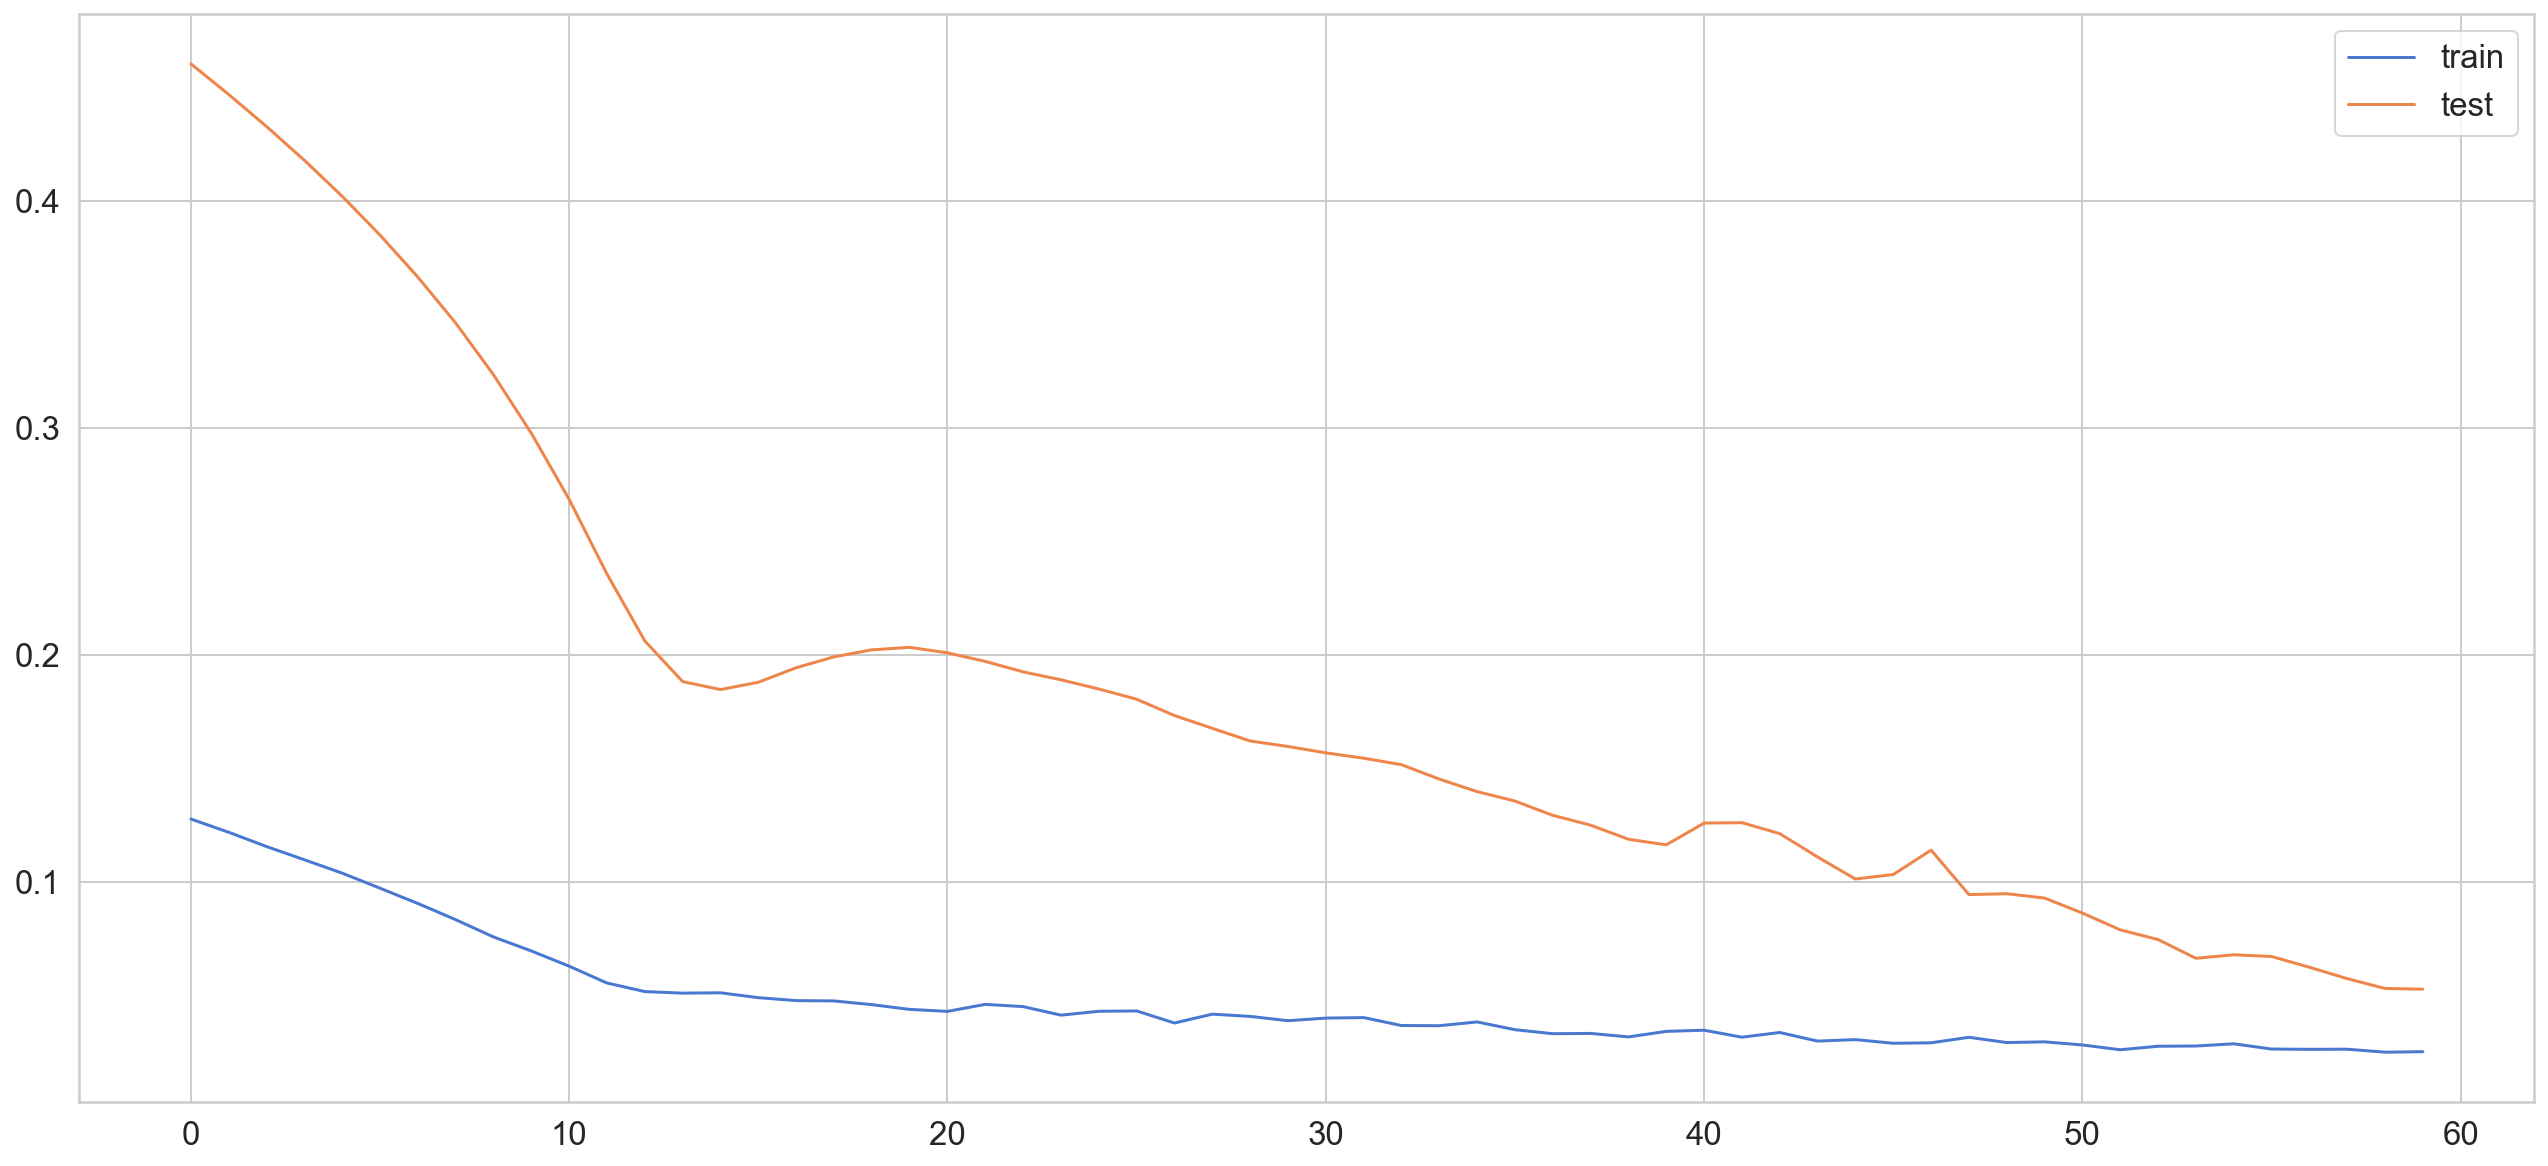

In [943]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [944]:
y_pred = model.predict(X_test)

In [945]:
def inverse_transform(arr):
    a=[]
    for i in arr:
        b=scaler.inverse_transform(i)
        a.append(b.tolist())
    return np.array(a)

In [946]:
X_test_inv = inverse_transform(X_test)
y_test_inv = inverse_transform(y_test)
y_pred_inv = inverse_transform(y_pred)

In [947]:
y_test_inv[0]

array([[27.],
       [23.],
       [21.],
       [19.],
       [21.],
       [21.],
       [20.],
       [21.]])

In [948]:
y_pred_inv[0]

array([[16.20421219],
       [21.21471405],
       [19.58056641],
       [17.81652641],
       [17.93258286],
       [21.00953102],
       [27.02363777],
       [35.22354889]])

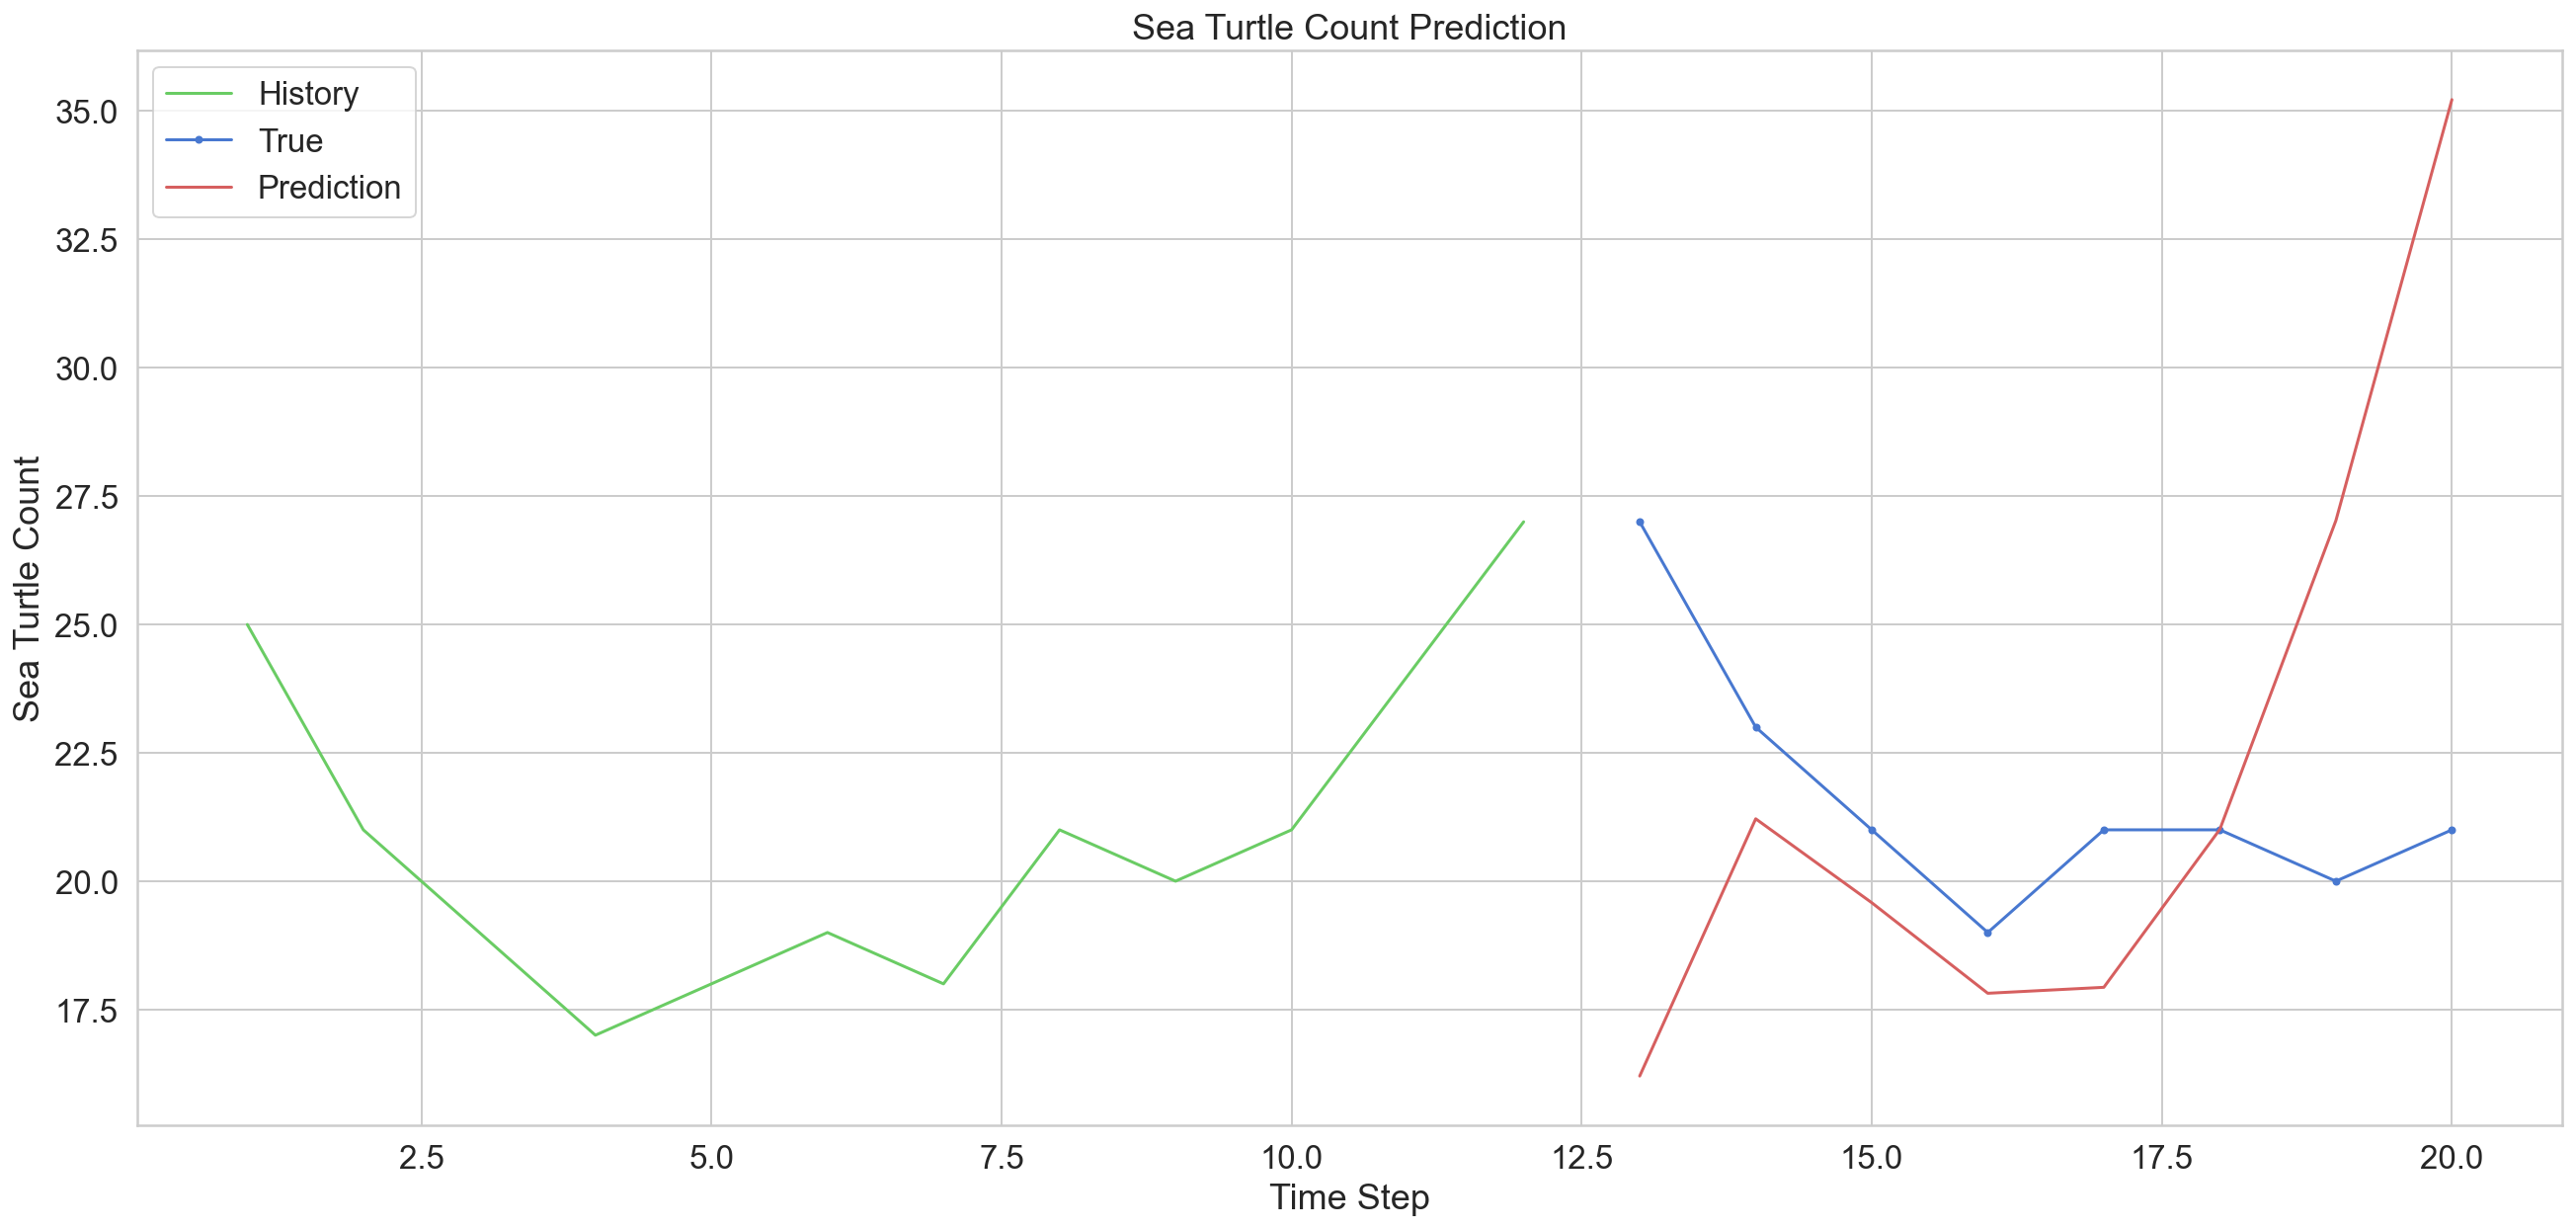

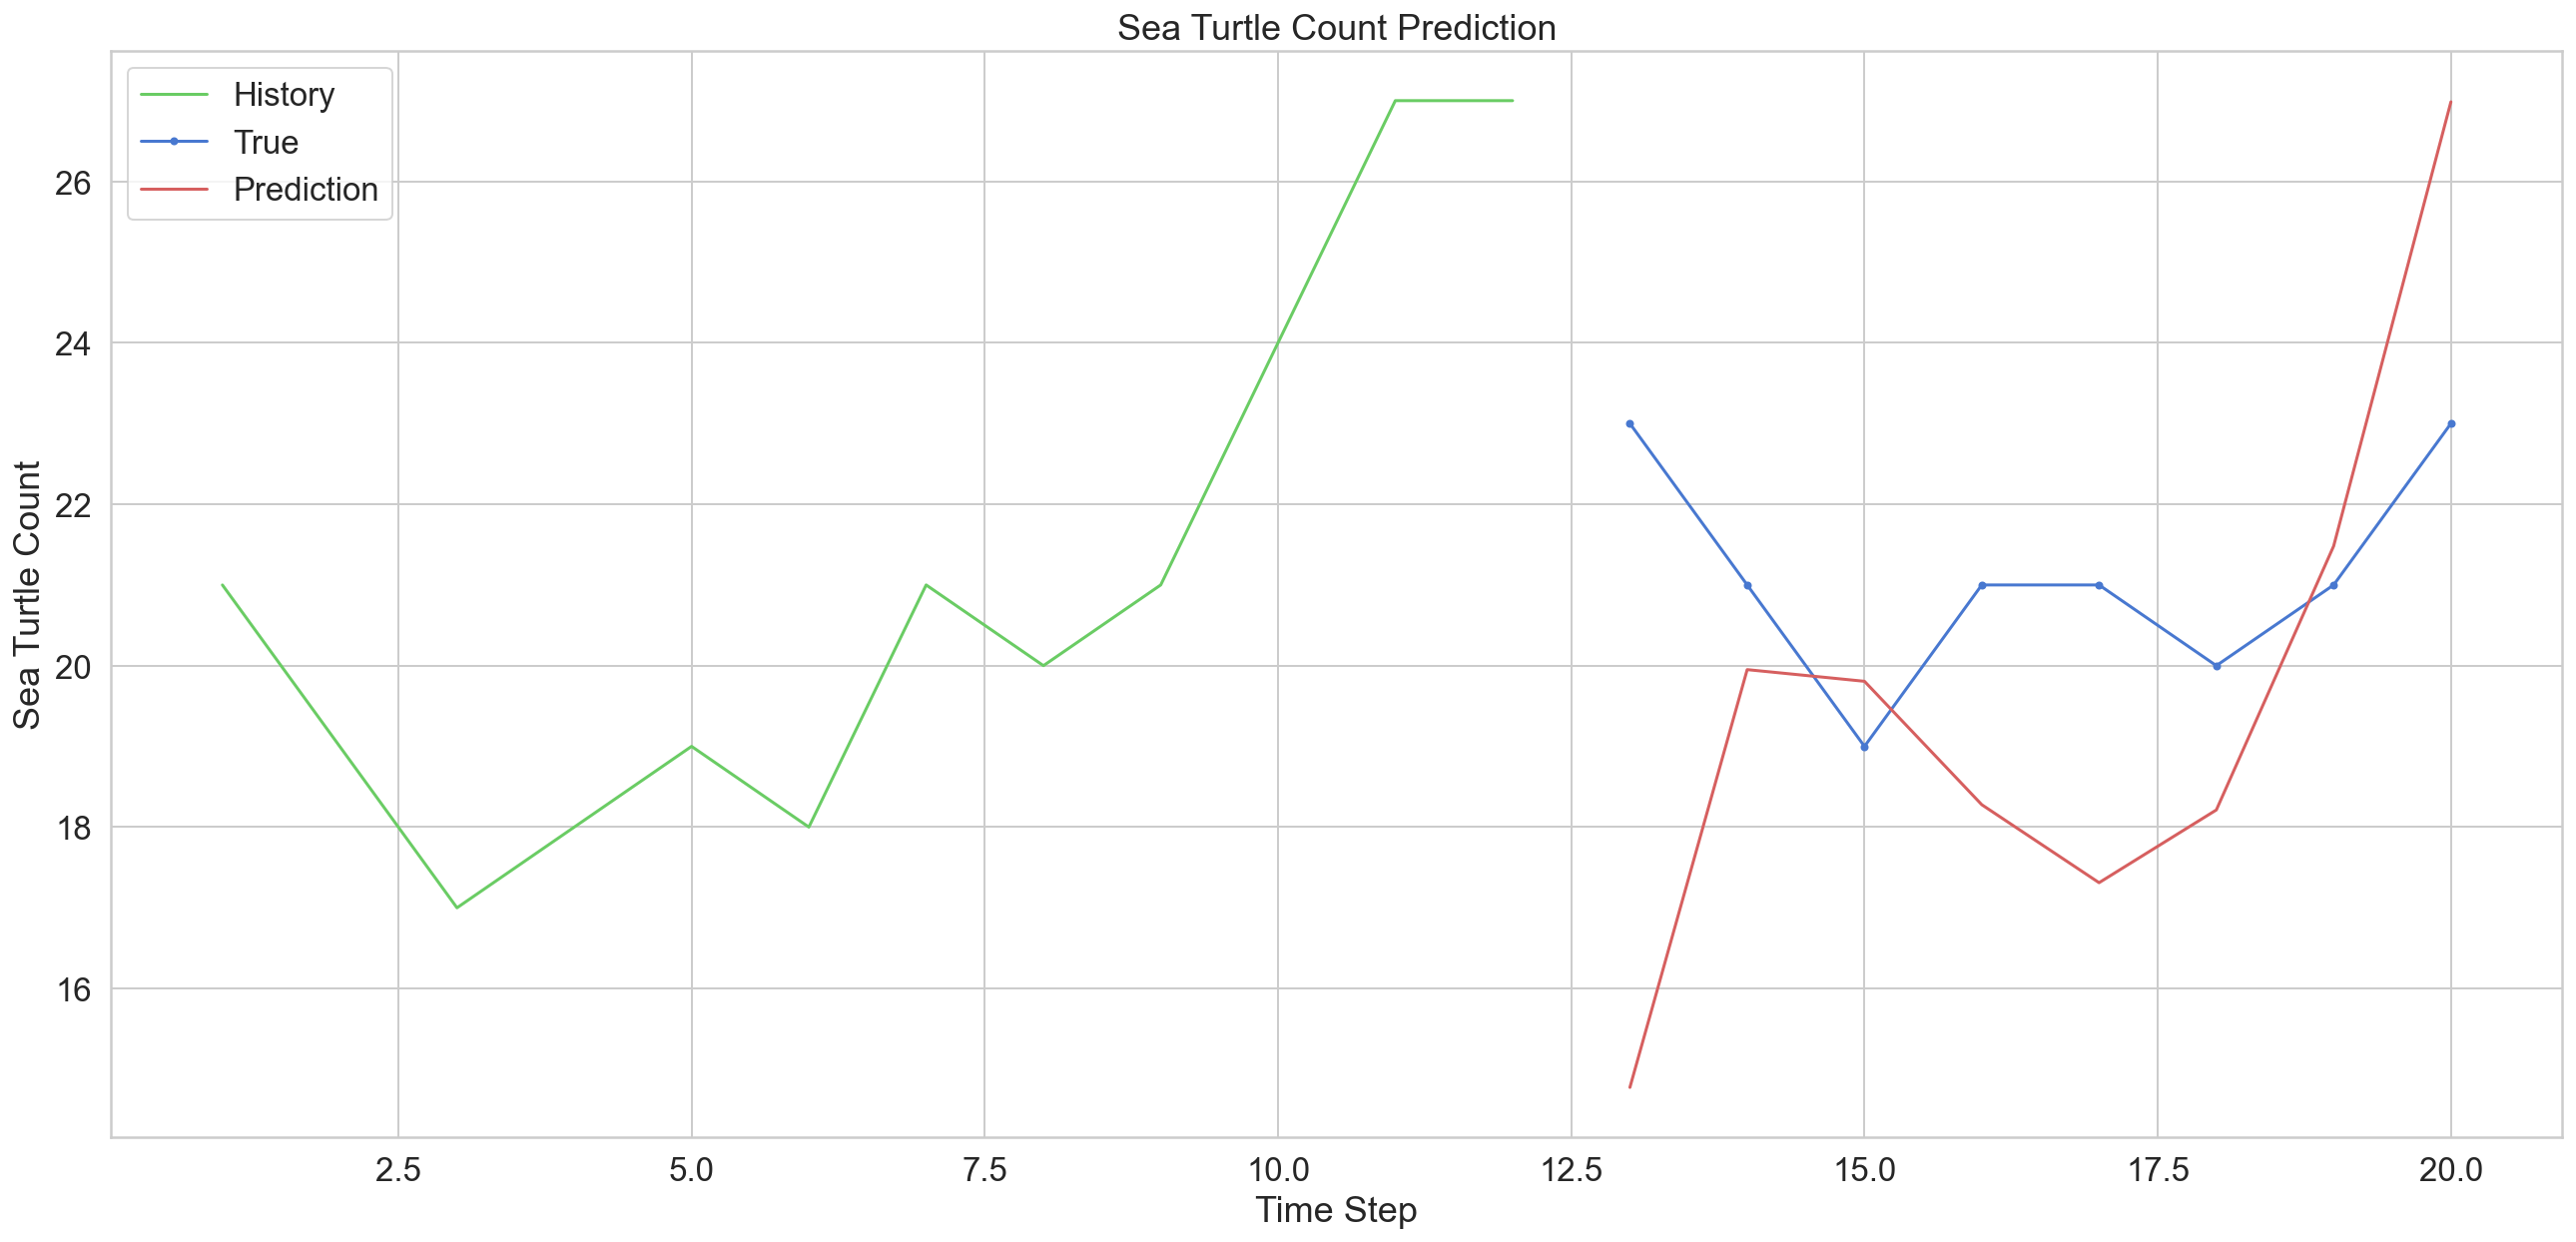

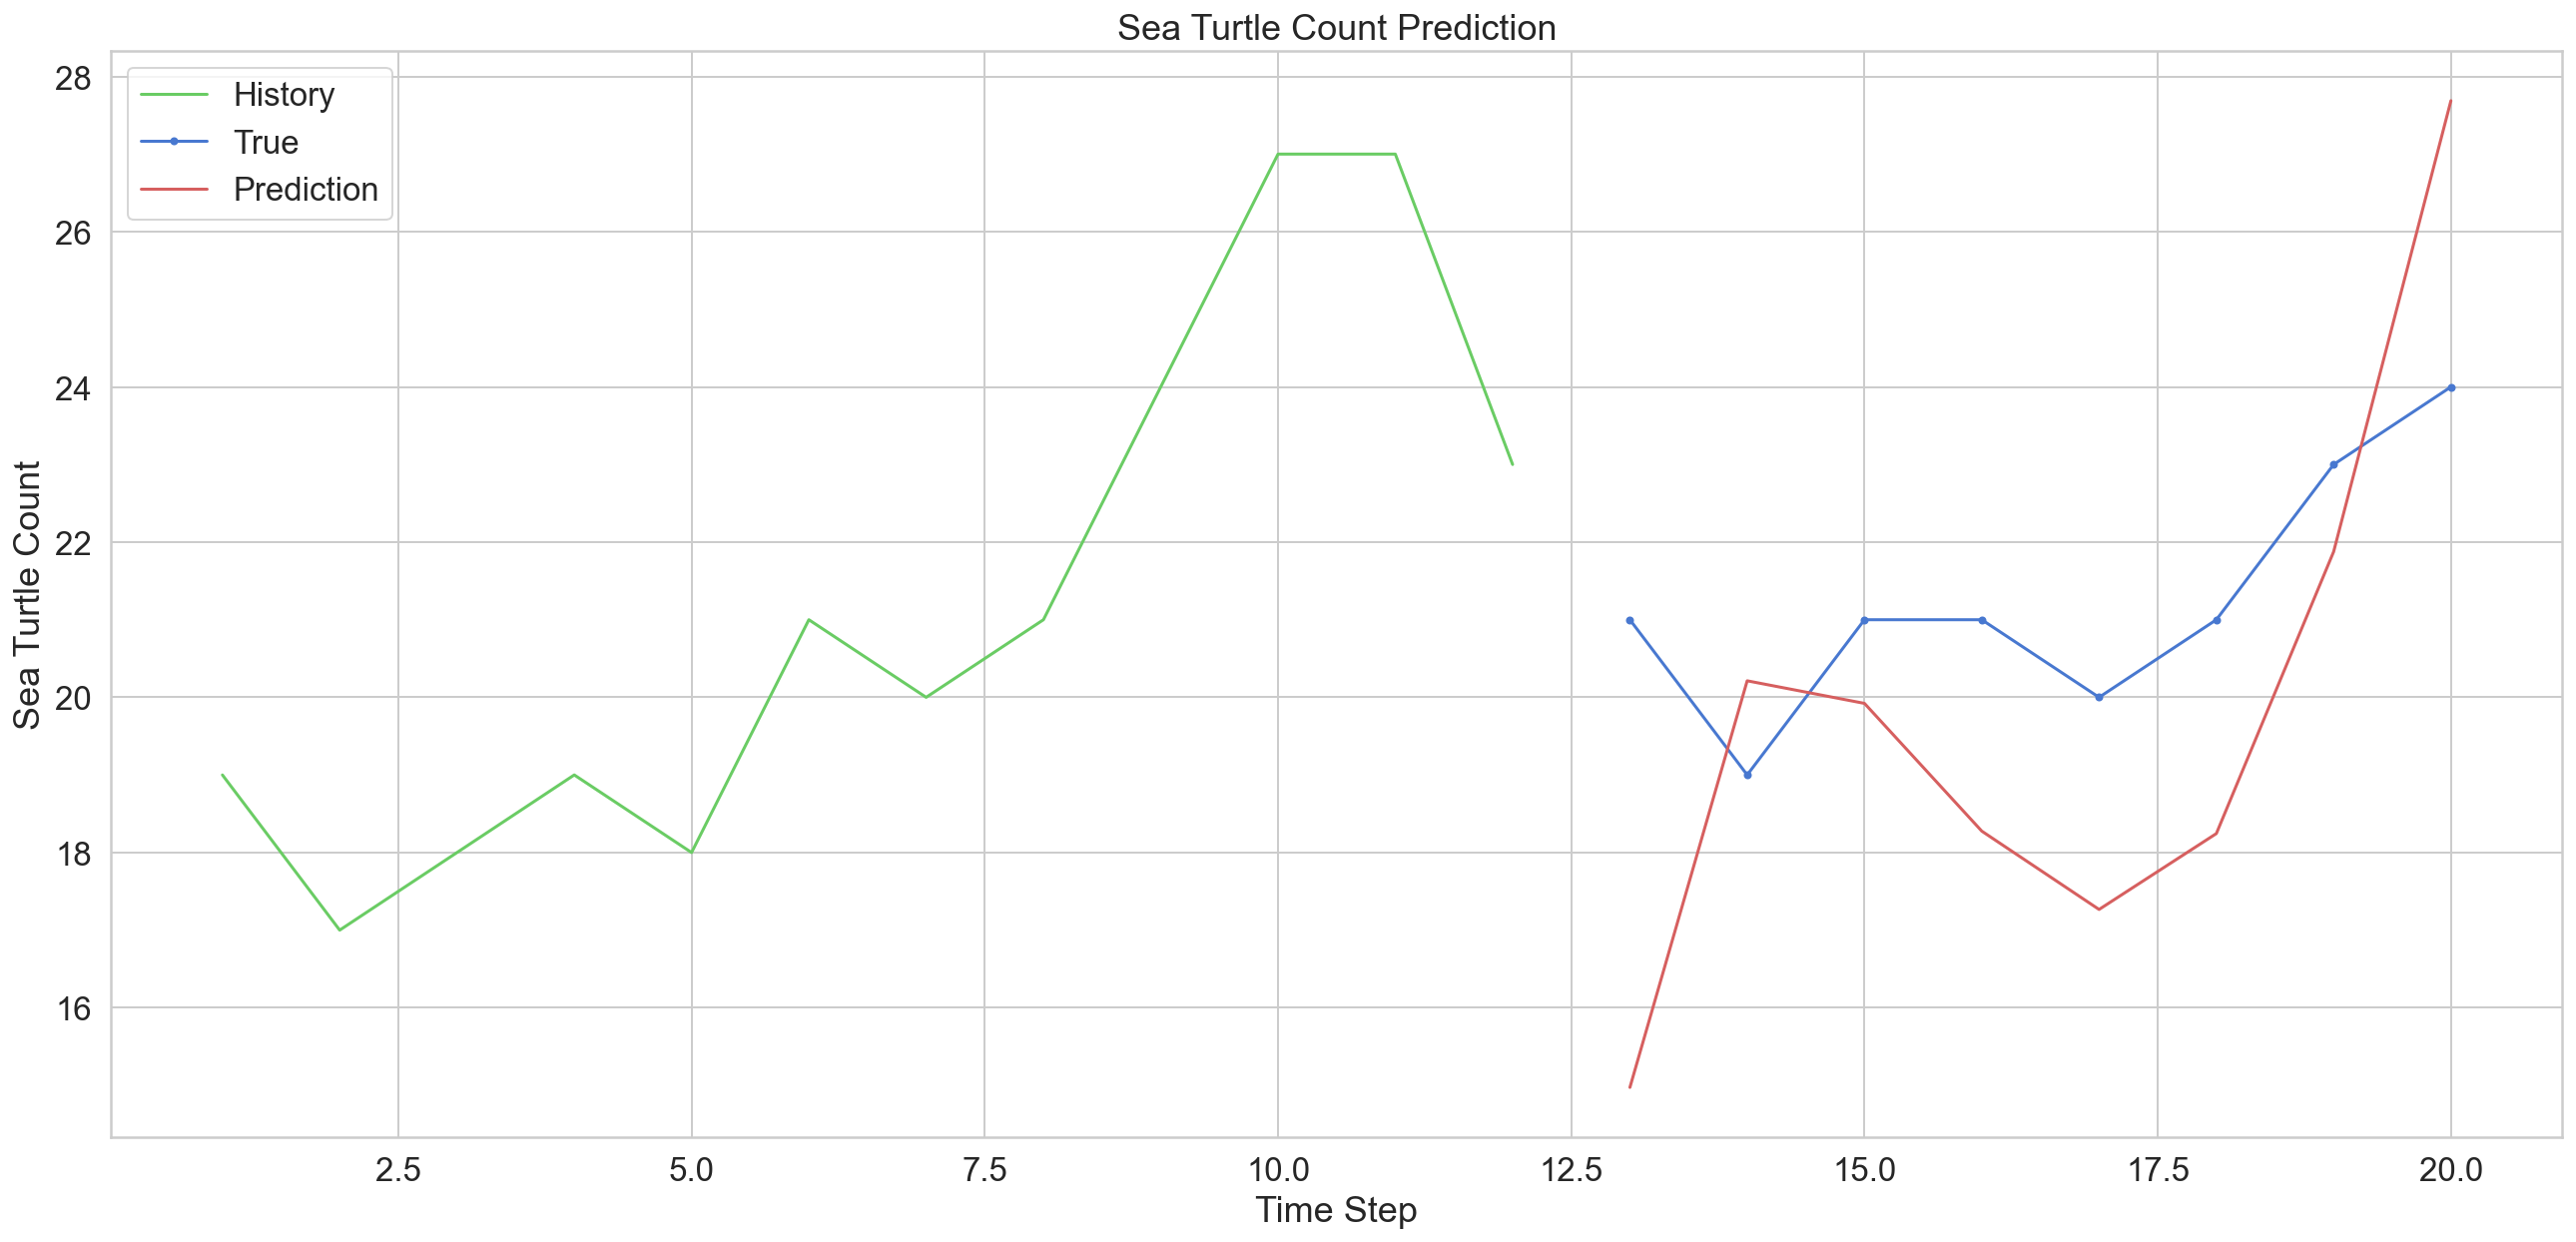

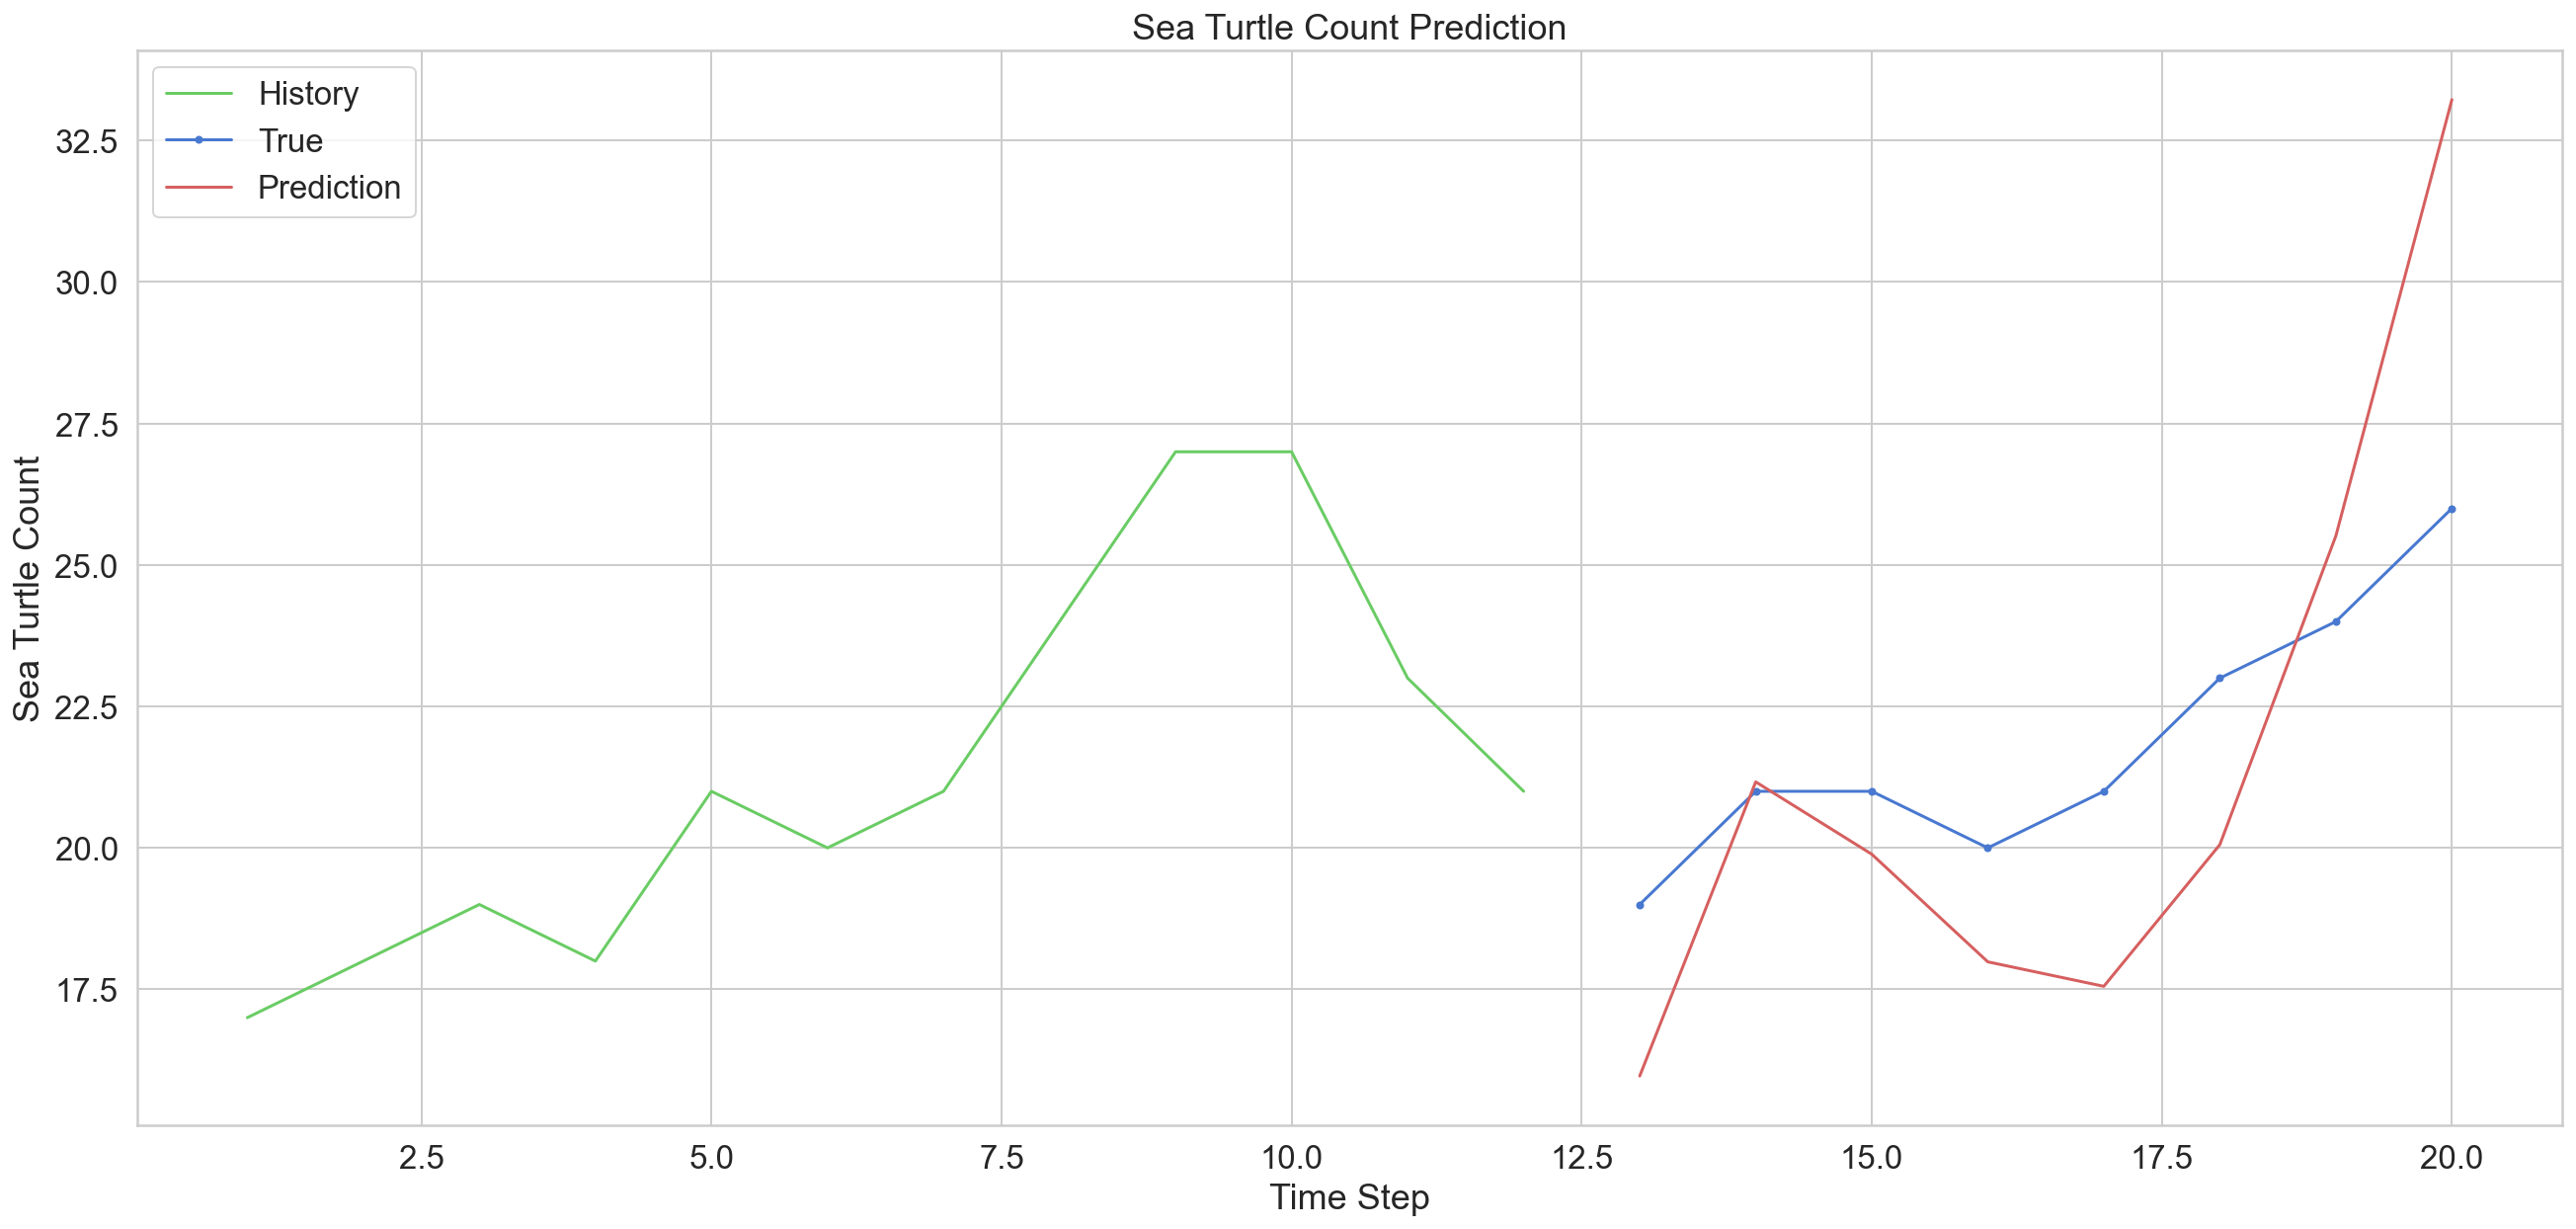

In [949]:
j=0
for i in X_test_inv:
    plt.plot( np.arange(1, len(i)+1),i[:,0], 'g', label="History")
    plt.plot(np.arange(len(i)+1, len(i)+1 + y_test_inv.shape[1]), y_test_inv[j][:,0], marker='.', label="True")
    plt.plot(np.arange(len(i)+1, len(i)+1+ y_test_inv.shape[1]), y_pred_inv[j][:,0], 'r', label="Prediction")
    plt.ylabel('Sea Turtle Count')
    plt.xlabel('Time Step')
    plt.title('Sea Turtle Count Prediction')
    plt.legend()
    plt.show();
    if j==3:
        break
    j+=1

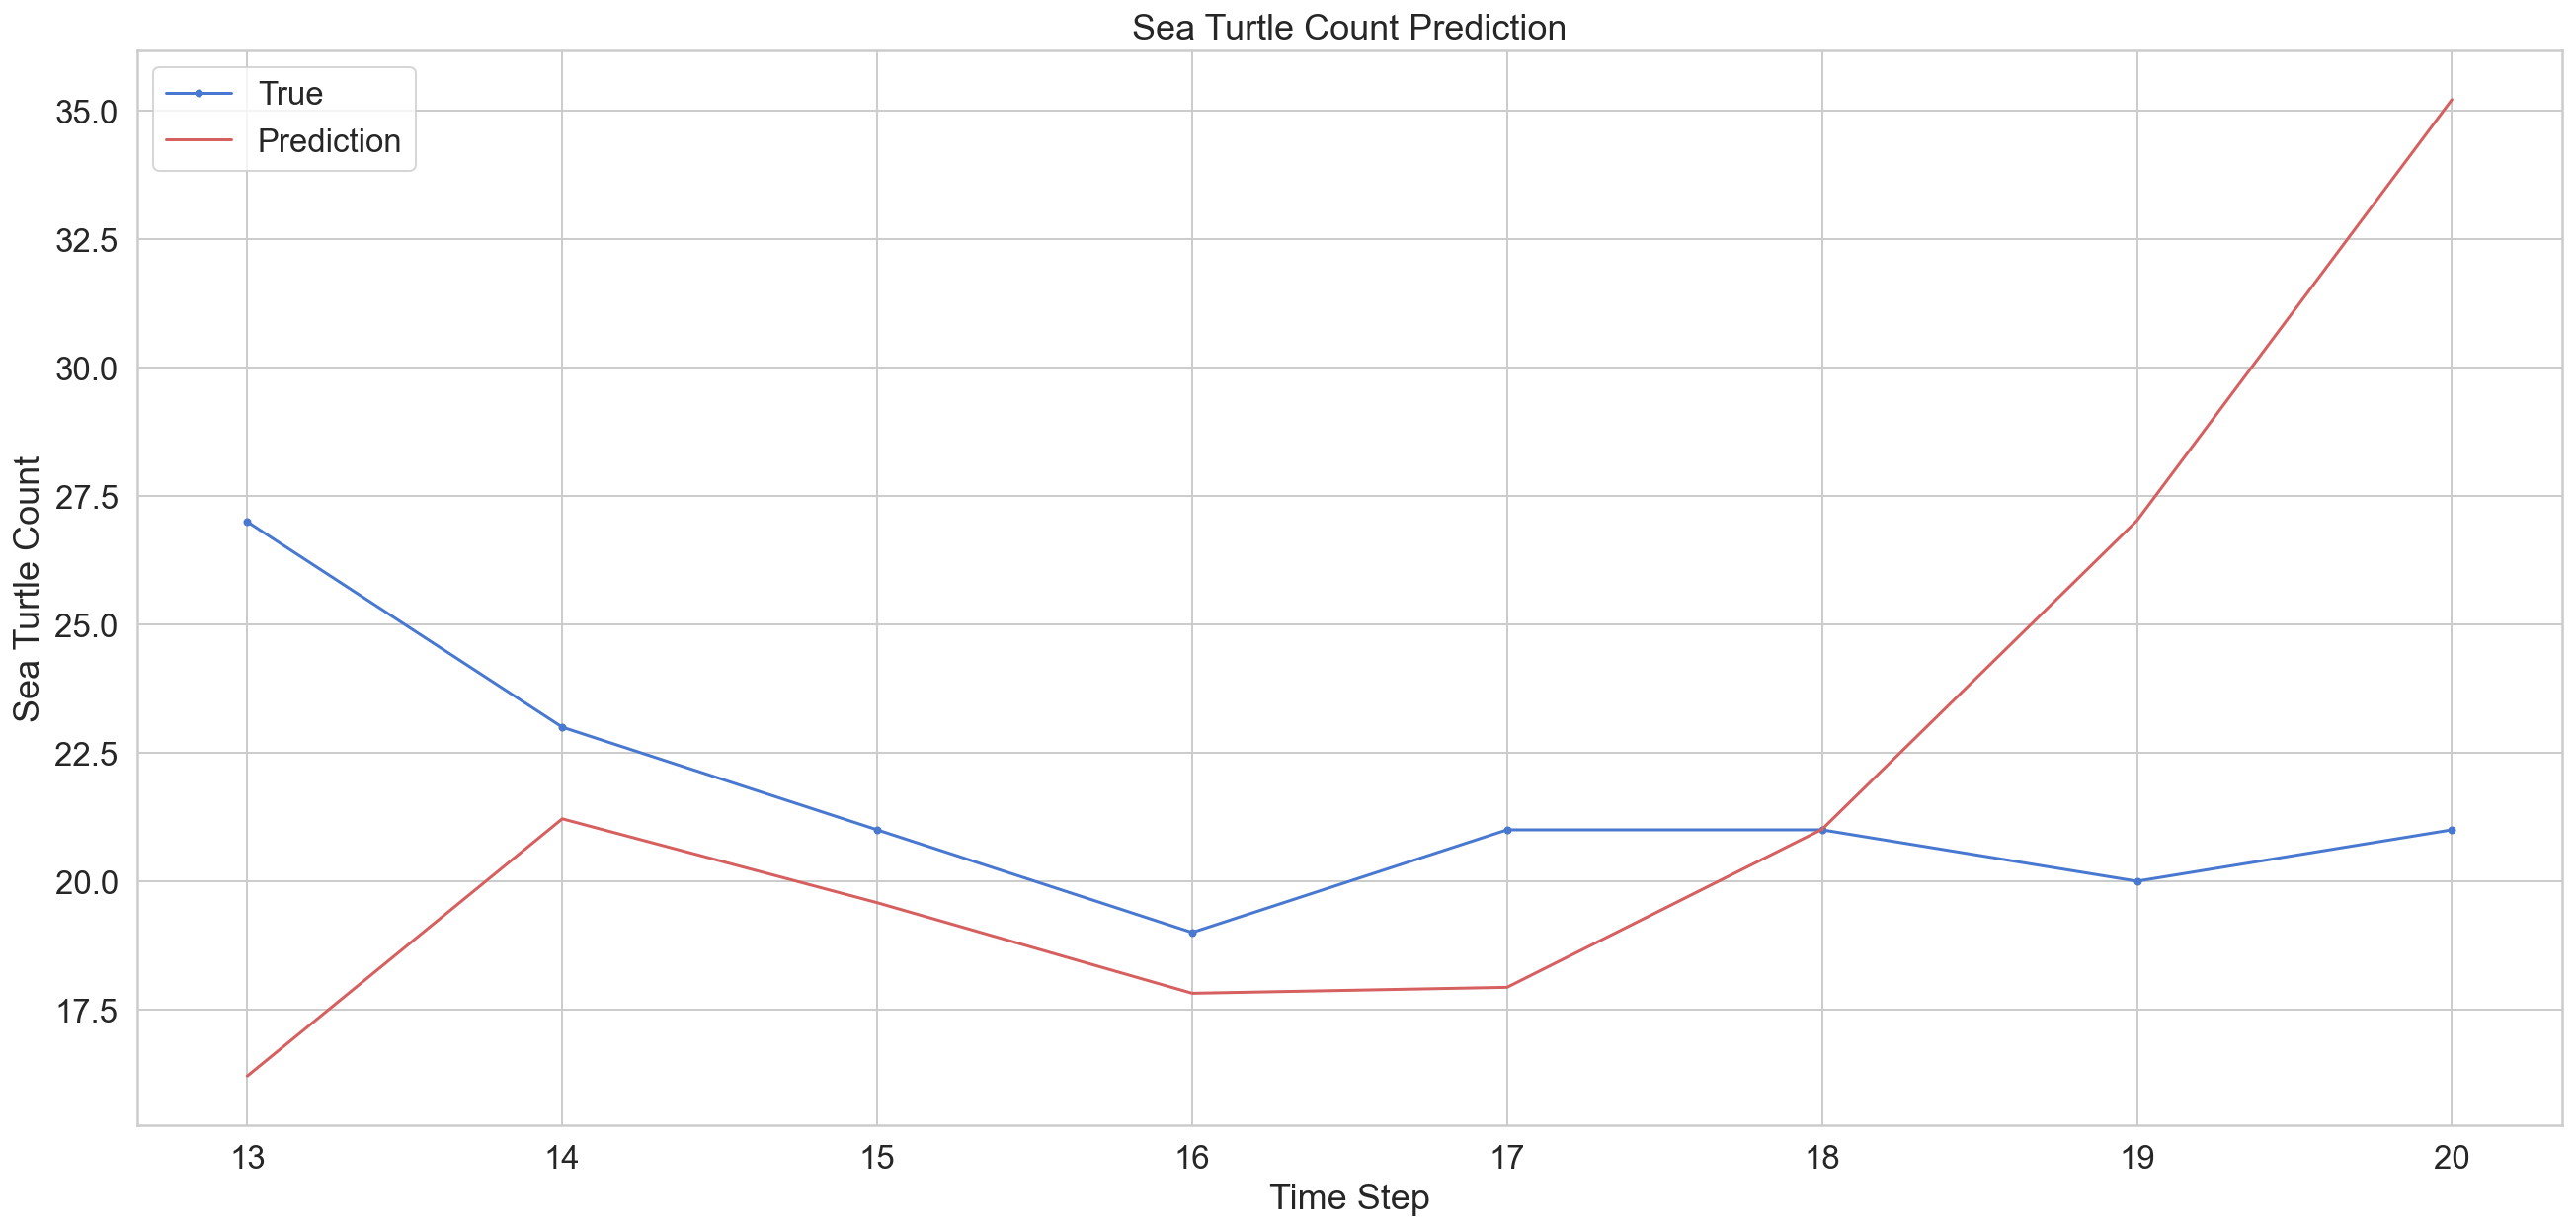

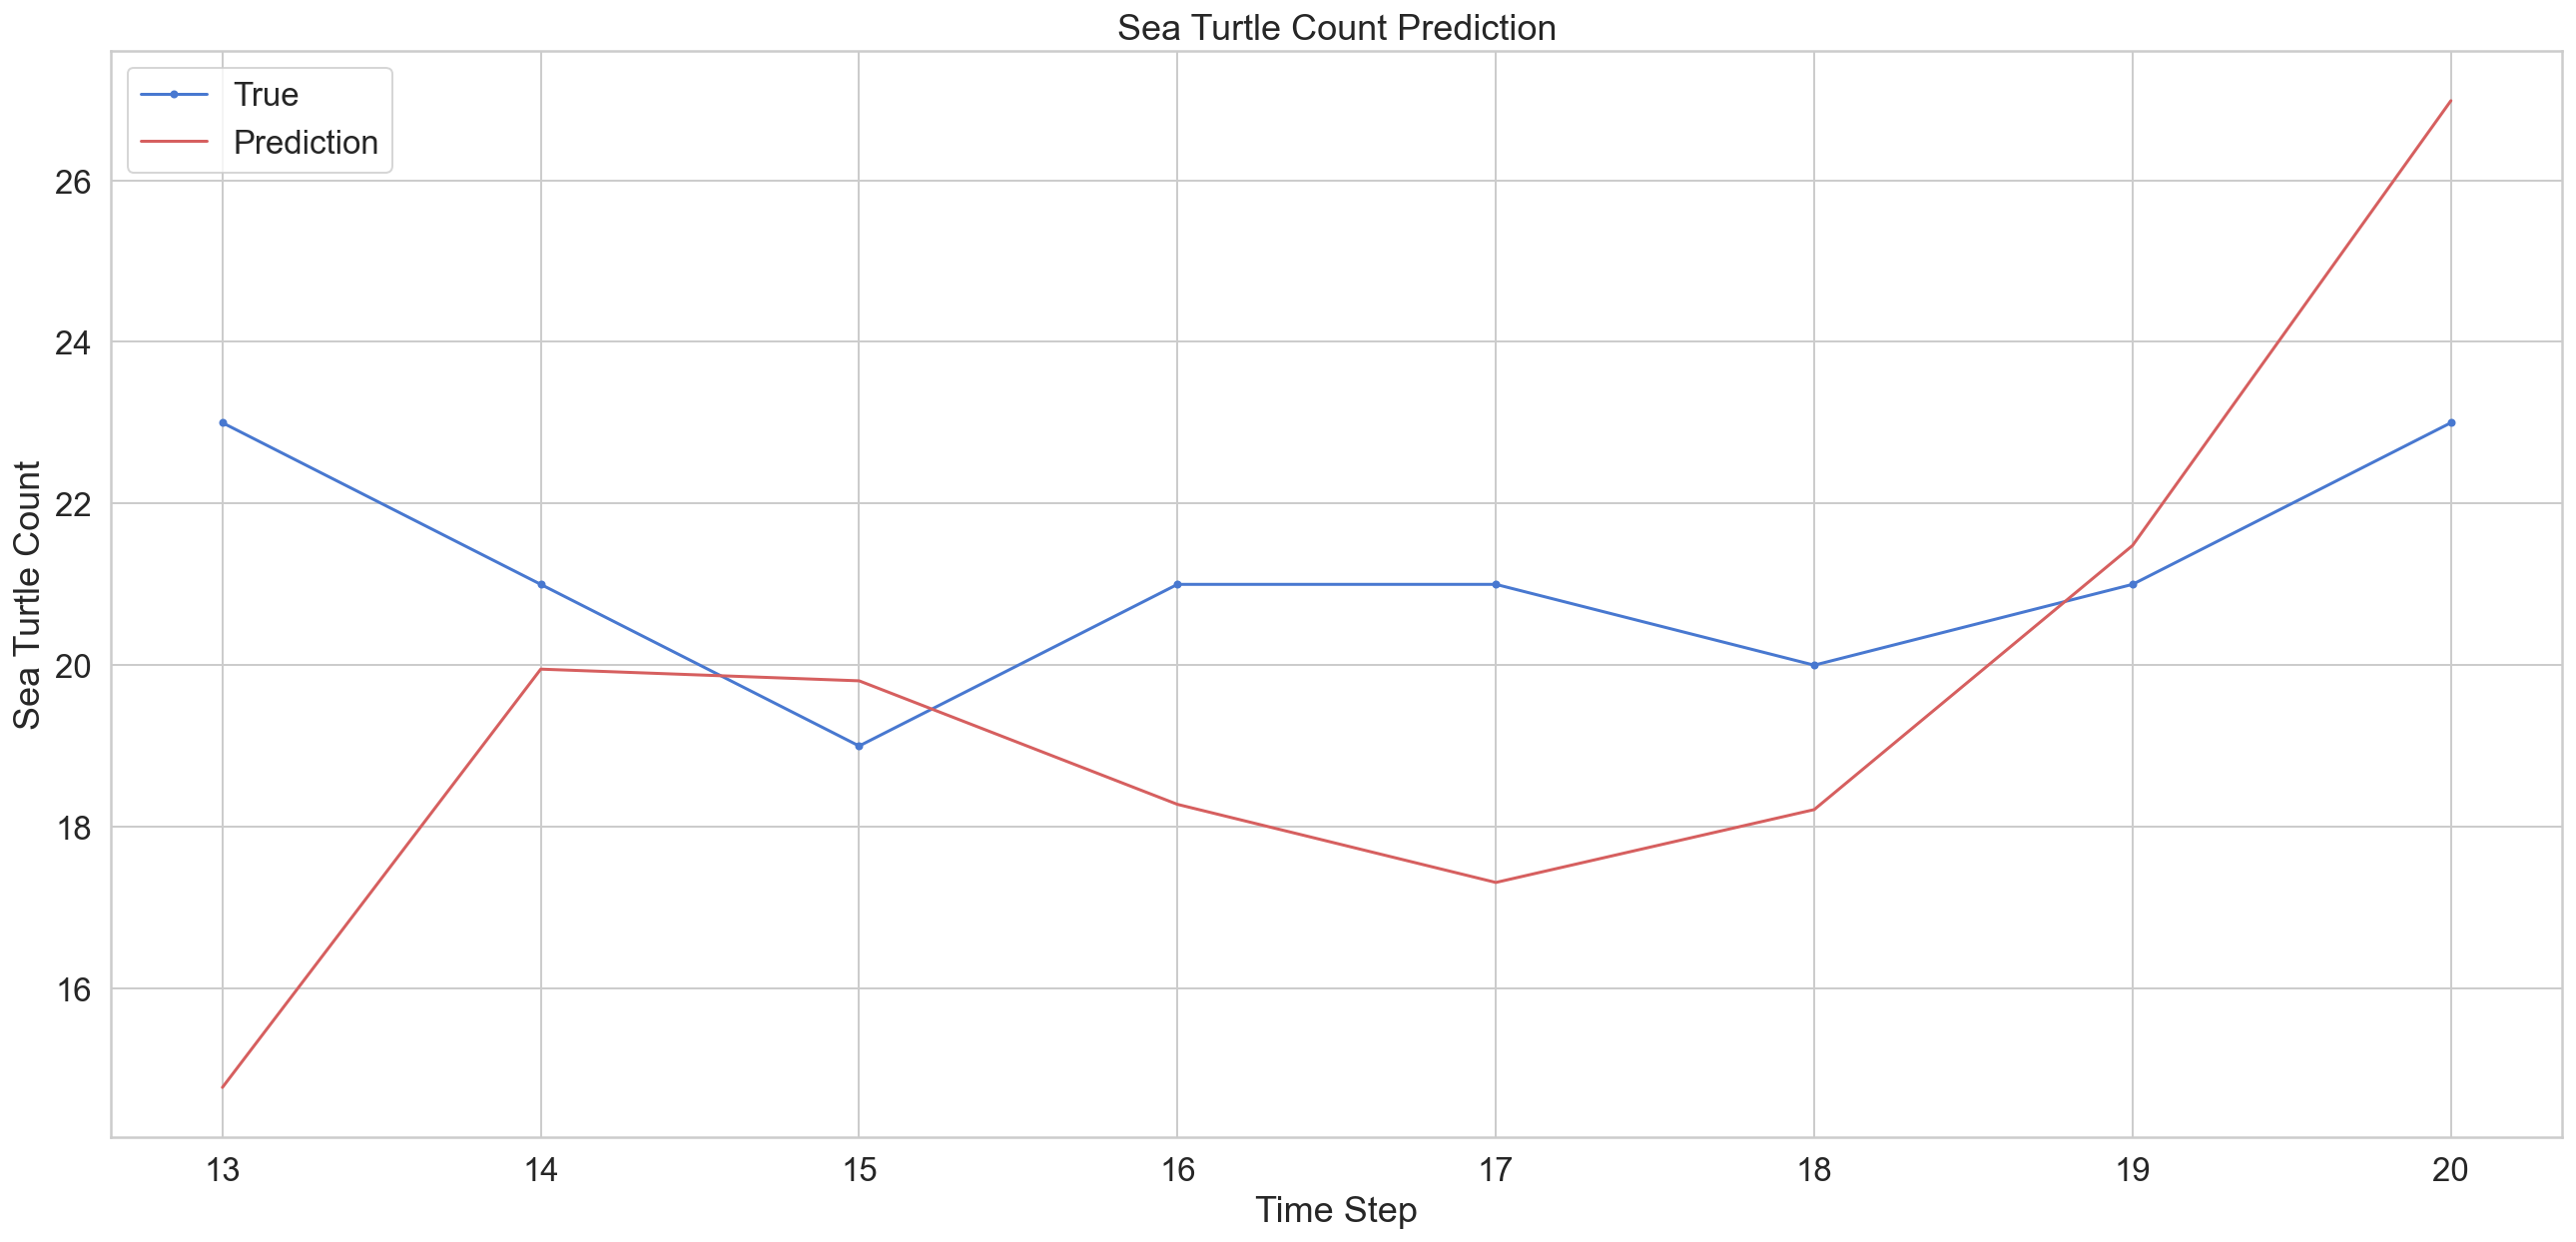

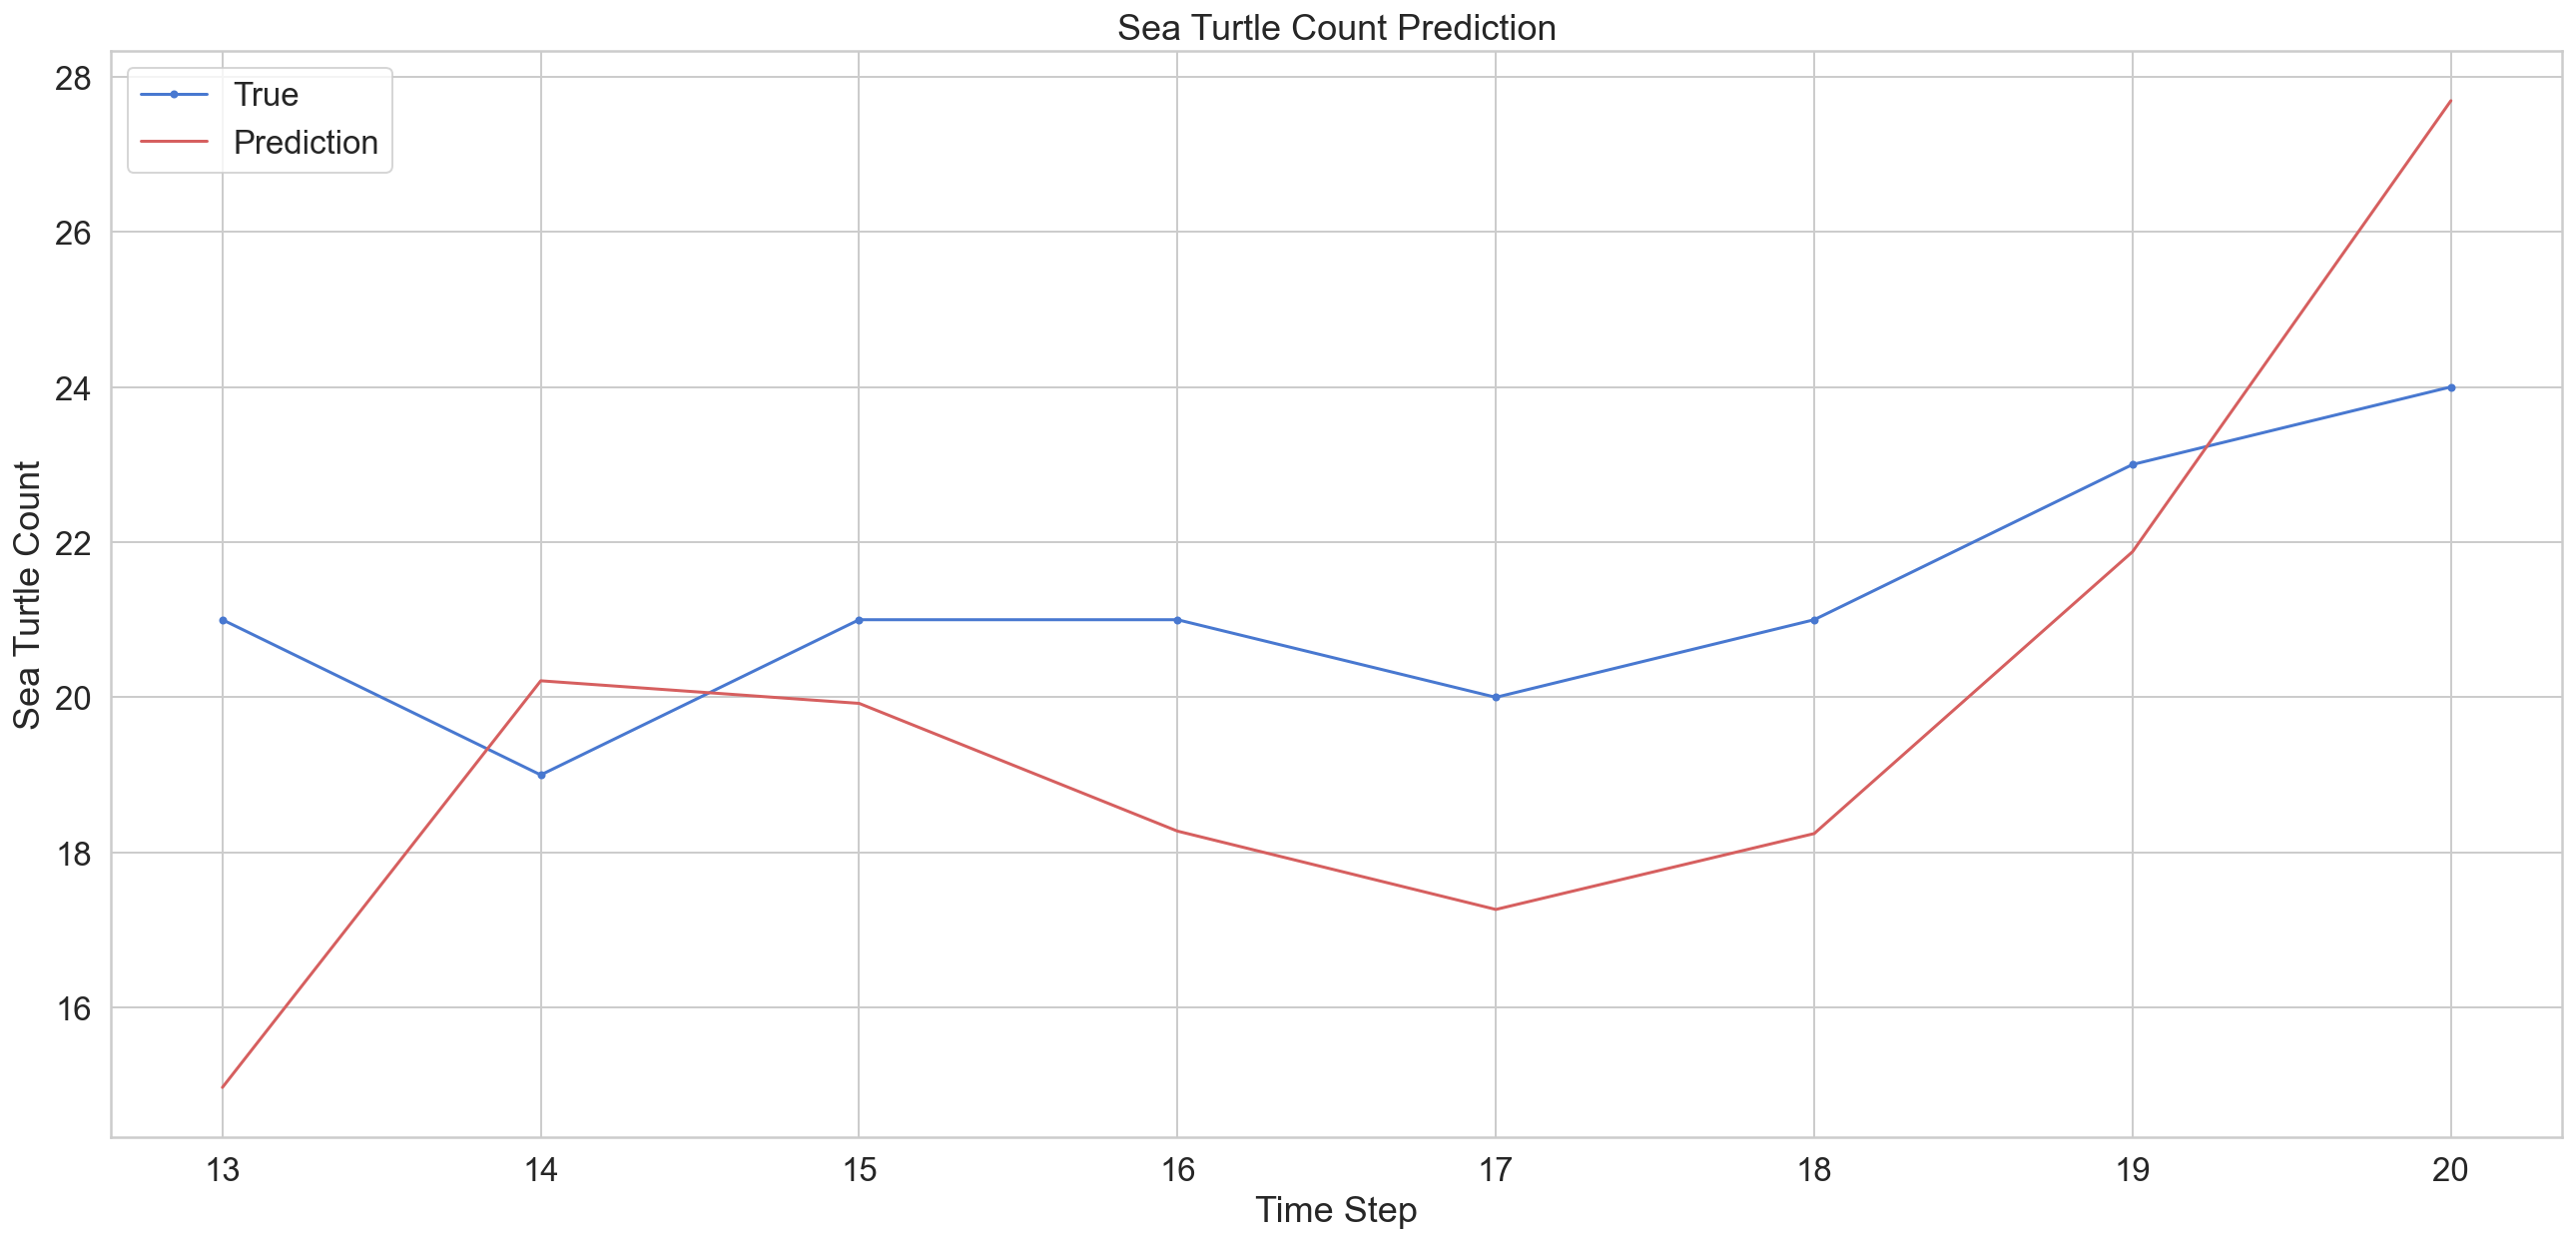

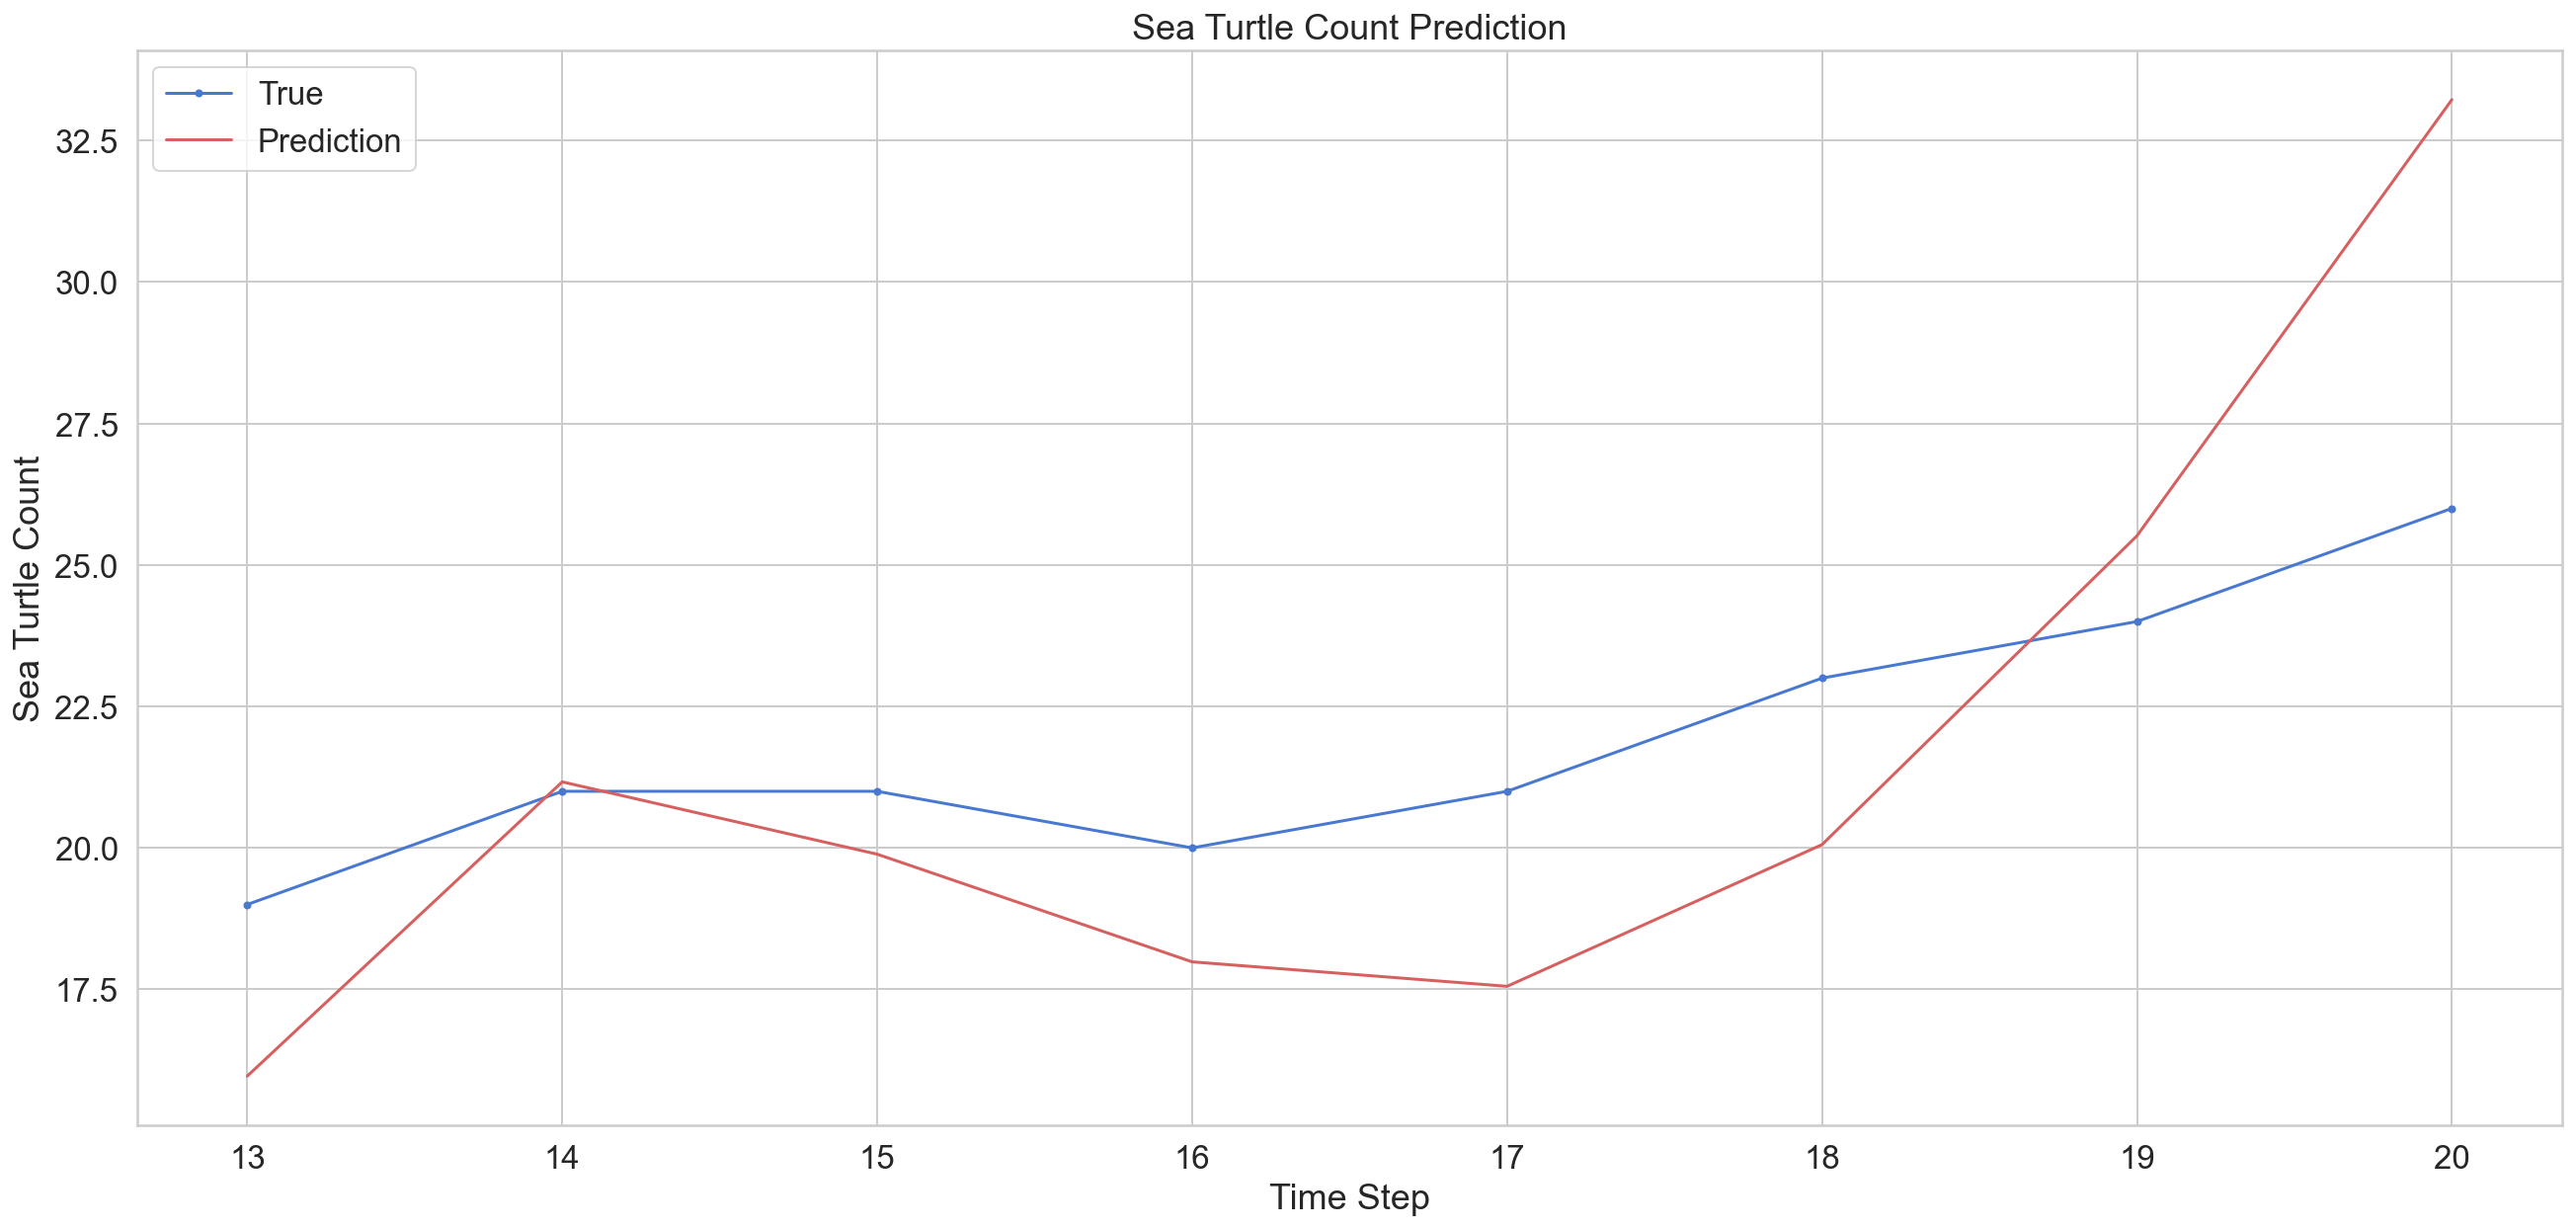

In [950]:
j=0
for i in X_test_inv:
    plt.plot(np.arange(len(i)+1, len(i)+1 + y_test_inv.shape[1]), y_test_inv[j][:,0], marker='.', label="True")
    plt.plot(np.arange(len(i)+1, len(i)+1+ y_test_inv.shape[1]), y_pred_inv[j][:,0], 'r', label="Prediction")
    plt.ylabel('Sea Turtle Count')
    plt.xlabel('Time Step')
    plt.title('Sea Turtle Count Prediction')
    plt.legend()
    plt.show();
    if j==3:
        break
    j+=1

In [951]:
MSE=mean_squared_error(y_test_inv[:,0], y_pred_inv[:,0])
print(f'Mean squared error : {MSE}') 

Mean squared error : 25.683295962292142


In [953]:
# model.save('SeaTurtleCountPredictionModel')

INFO:tensorflow:Assets written to: SeaTurtleCountPredictionModel\assets
